In [1]:
from copy import copy,deepcopy
from itertools import combinations
import json
import textwrap


from fisher import pvalue_npy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
import requests
import requests_cache


requests_cache.install_cache(
    "pfocr_cache",
    allowable_methods=['GET', 'POST'],
    stale_if_error=False,
)
#requests_cache.remove_expired_responses()

# BTE Visual Explainer

TLDR: skip ahead to the "View TRAPI results and figures" section to see TRAPI results in the context of figures.

The goal of this notebook is to show how BTE + PFOCR can serve as a Visual Explainer by showing how one disease, gene or small molecule is related to another in context of PFOCR figures.

Note this currently only works on queries with nodes of categories supported by PFOCR, e.g., `biolink:Gene`, `biolink:SmallMolecule`, `biolink:Disease`. TODO: update the Fisher's Exact test to work with node categories not in PFOCR.

## Get BTE TRAPI Results

In [3]:
query = {
    "message": {
        "query_graph": {
            "edges": {
                "e0": {
                    "subject": "n0",
                    "object": "n1",
                    "predicates": [
                        "biolink:entity_regulates_entity",
                        "biolink:genetically_interacts_with"
                    ]
                },
                "e1": {
                    "subject": "n1",
                    "object": "n2",
                    "predicates": [
                        "biolink:related_to"
                    ]
                }
            },
            "nodes": {
                "n0": {
                    "ids": [
                        "NCBIGene:7454"
                    ],
                    "categories": [
                        "biolink:Gene"
                    ]
                },
                "n1": {
                    "categories": [
                        "biolink:Gene"
                    ],
                },
                "n2": {
                    "categories": [
                        "biolink:SmallMolecule"
                    ],
                    "ids": [
                        "MESH:D006153"
                    ]
                }
            }
        }
    }
}

trapi_response = requests.post("http://localhost:3000/v1/query", json=query)
#trapi_response = requests.post("https://api.bte.ncats.io/v1/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/rtxkg2/v1.2/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/arax/v1.2/query", json=query)
print(trapi_response.status_code)
if trapi_response.status_code != 200:
    raise Exception(trapi_response.text)
if trapi_response.from_cache:
    print(f"got response from cache")

trapi_message = trapi_response.json()["message"]

if len(trapi_message["results"]) == 0:
    raise Exception(f'No results returned')

200
got response from cache


Analyze this GraphML file in Cytoscape: ./bte_visual_explainer_query_template.graphml


{('n0',
  'n1'): Text(-0.22842198837258673, 0.4989060497921471, 'biolink:entity_regulates_entity\nbiolink:genetically_interacts_with'),
 ('n1',
  'n2'): Text(0.22892292190402752, -0.4999999999999998, 'biolink:related_to')}

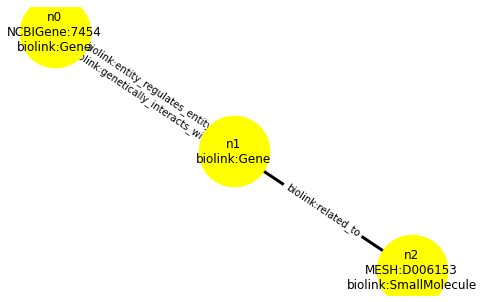

In [4]:
from collections import defaultdict


G = nx.Graph()
query_node_labels = {}
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    node_categories = v.get('categories', [])
    G.add_node(k, categories=', '.join(node_categories))
    query_node_labels[k] = '\n'.join([k] + node_ids + node_categories)
    #G.add_node(k, color='red')

query_edge_labels = {}
q_node_id_keys = set(['object', 'subject'])
for q_edge_id,edge_v in query['message']['query_graph']['edges'].items():
    for predicate in edge_v['predicates']:
        G.add_edge(edge_v['subject'], edge_v['object'], predicate=predicate)
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=', '.join(edge_v['predicates']))
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=[1,2,3])
    #G.add_edge(edge_v['subject'], edge_v['object'])
    query_edge_labels[(edge_v['subject'], edge_v['object'])] = '\n'.join(edge_v['predicates'])

query_template_f = './bte_visual_explainer_query_template.graphml'
print(f'Analyze this GraphML file in Cytoscape: {query_template_f}')
nx.write_graphml(G, query_template_f)

options = {
    'node_color': 'yellow',
    'node_size': 5000,
    'edge_color': 'black',
    'width': 3,
}
query_template_layout = nx.spring_layout(G)
nx.draw(G, pos=query_template_layout, **options)
nx.draw_networkx_labels(G, query_template_layout, labels=query_node_labels, font_size=12,
                        font_color='k', font_family='sans-serif',
                        font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                        verticalalignment='center', ax=None, clip_on=False)
nx.draw_networkx_edge_labels(G, pos=query_template_layout,
                             edge_labels=query_edge_labels,
                             label_pos=0.5, 
                             font_size=10, font_color='k', font_family='sans-serif',
                             font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                             verticalalignment='center', ax=None, rotate=True, clip_on=True)

In [5]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

curie_categories = set()
for v in query["message"]["query_graph"]["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [6]:
# for genes/gene products, chemicals and diseases
preferred_prefixes = set(["NCBIGene", "MESH"])
unified_names = set()
unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    for category in v["categories"]:
        curie_categories.add(category)
        
    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]
            
            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")
            
            unified_curie = None
            intersecting_unified_curies = unified_curies.intersection(set(curies))
            if len(intersecting_unified_curies) > 1:
                raise Exception(f"matching multiple: {k} to {list(intersecting_unified_curies)}")
            elif len(intersecting_unified_curies) == 1:
                unified_curie = list(intersecting_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        unified_curies.add(unified_curie)
                        break
                        
            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break
                    
                #raise Exception(f"failed to find a unified curie for {k} in {curies}")
                
            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)
            
            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                    unified_names.add(name)
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")
                    #raise Exception(f"curie{curie} has multiple names: {curie_to_name[curie]} and {name}")

In [7]:
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["message"]["query_graph"]["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)
                
query_nodes_with_ids = set()
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        query_nodes_with_ids.add(k)
                
for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_curie")
    columns.append(f"{q_node_id}_unified_curie")
    
columns.append("trapi_result_curie_combo")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

unified_curie_columns = []
for q_node_id in q_node_ids:
    unified_curie_columns.append(f"{q_node_id}_unified_curie")

In [8]:
trapi_results = trapi_message["results"]

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)
        
    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curies = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")
            
            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curies.add(unified_curie)
                    row_data_template[qnode_id + "_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie
                    
    if len(trapi_result_curies) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue
        
    row_data_template["trapi_result_curie_combo"] = tuple(sorted(trapi_result_curies))
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas
        
results_df = pd.DataFrame.from_records(result_row_data, columns=columns).drop_duplicates()

## Match up BTE TRAPI Results & PFOCR

We're going to try using PFOCR to filter and prioritize the results.

First we need to get the PFOCR Data. We could get it from the API, but for now, we'll just go ahead and download the entire JSON file we gave to BTE.

In [9]:
pfocr_url = "https://www.dropbox.com/s/1f14t5zaseocyg6/bte_chemicals_diseases_genes.ndjson?dl=1"
pfocr_request = requests.get(pfocr_url)
print(f"status_code: {pfocr_request.status_code}")
if pfocr_request.status_code != 200:
    print(pfocr_request.text)

status_code: 200


In [10]:
curies_to_figure_ids = {}
figure_id_to_curies = {}
figure_id_to_pfocr_result = {}
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    curies_key = tuple(sorted(curies))
    if curies_key not in curies_to_figure_ids:
        curies_to_figure_ids[curies_key] = []
    curies_to_figure_ids[curies_key].append(figure_id)

In [11]:
from SetSimilaritySearch import SearchIndex

# the reference sets are supposed to be from PFOCR only
reference_sets = list()
for curies in set(curies_to_figure_ids.keys()):
    reference_sets.append(set(curies))
# but in order to calculate the scores correctly,
# the SetSimilaritySearch library requires that
# every curie from the bte results need to be
# mentioned at least once in the reference set.
# That's the only reason we add them below, as
# one large set.

unified_curie_columns = [
    q_node_id + "_unified_curie" for q_node_id in q_node_ids
]

trapi_result_curie_combos = set()
for i, df in results_df[unified_curie_columns].drop_duplicates().iterrows():
    trapi_result_curies = []
    for unified_curie_column in unified_curie_columns:
        trapi_result_curies.append(
            df[unified_curie_column]
        )
    trapi_result_curie_combos.add(tuple(sorted(
        trapi_result_curies
    )))
    
reference_set = set()
for trapi_result_curie_combo in trapi_result_curie_combos:
    reference_set |= set(trapi_result_curie_combo)
reference_sets.append(reference_set)

matchable_node_min = 2
matchable_node_count = len(q_node_ids)
index = SearchIndex(reference_sets, similarity_func_name="containment", 
    similarity_threshold=matchable_node_min/matchable_node_count)

trapi_figure_overlap_rows = []
for trapi_result_curie_combo in trapi_result_curie_combos:
    trapi_curies = set(trapi_result_curie_combo)
    results = index.query(trapi_curies)
    for result in results:
        figure_curie_combos = reference_sets[result[0]]
        figure_curie_key = tuple(sorted(figure_curie_combos))
        
        # needed to not match bte results to themselves
        if figure_curie_key in curies_to_figure_ids:
            figure_ids = curies_to_figure_ids[figure_curie_key]
        else:
            continue
            
        score = result[1]
        
        common_curies = trapi_curies.intersection(figure_curie_combos)
        for figure_id in figure_ids:
            pfocr_result = figure_id_to_pfocr_result[figure_id]
            trapi_figure_overlap_rows.append({
                "figure_id": figure_id,
                "figure_url": pfocr_result["associatedWith"]["figureUrl"],
                "figure_title": pfocr_result["associatedWith"]["title"],
                "trapi_result_curie_combo": trapi_result_curie_combo,
                "figure_curie_combo": figure_curie_key,
                "overlap_curie_combo": tuple(sorted(common_curies)),
                "score": score,
            })

trapi_figure_overlap_df = pd.DataFrame.from_records(trapi_figure_overlap_rows)
trapi_curie_combo_count_by_figure_df = trapi_figure_overlap_df[
    ["figure_id", "trapi_result_curie_combo"]
].rename(columns={
    "trapi_result_curie_combo": "trapi_curie_combo_count"
}).groupby("figure_id").count().sort_values(
    by="trapi_curie_combo_count", ascending=False
)

trapi_result_figure_score_df = trapi_figure_overlap_df[
    ["trapi_result_curie_combo", "score"]
].rename(
    columns={"score": "cumulative_trapi_result_curie_combo_figure_score"}
).groupby("trapi_result_curie_combo").sum().sort_values(
    by="cumulative_trapi_result_curie_combo_figure_score", ascending=False
)
results_with_figures_df = trapi_figure_overlap_df.merge(
    results_df,
    on="trapi_result_curie_combo",
    how="left"
).merge(
    trapi_result_figure_score_df.reset_index(),
    on="trapi_result_curie_combo",
    how="left",
    validate="many_to_one"
).merge(
    trapi_curie_combo_count_by_figure_df.reset_index().rename(columns={
        "trapi_curie_combo_count": "trapi_curie_combo_count_by_figure"
    }),
    on="figure_id",
    how="left",
    validate="many_to_one"
).sort_values(
    by="cumulative_trapi_result_curie_combo_figure_score", ascending=False
)

### Fisher's Exact Test

Let's quantify the match up between figures and TRAPI results.

In [12]:
all_genes = set()
gene_instance_count = 0
all_chemicals = set()
chemical_instance_count = 0
all_diseases = set()
disease_instance_count = 0
for figure_id, pfocr_result in figure_id_to_pfocr_result.items():
    genes = pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]
    for gene in genes:
        gene_instance_count += 1
        all_genes.add(gene)

    chemicals = pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]
    for chemical in chemicals:
        chemical_instance_count += 1
        all_chemicals.add(chemical)

    diseases = pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]
    for disease in diseases:
        disease_instance_count += 1
        all_diseases.add(disease)

curie_category_to_curies = {
    "biolink:ChemicalEntity": all_chemicals,
    "biolink:SmallMolecule": all_chemicals,
    "biolink:Disease": all_diseases,
    "biolink:Gene": all_genes,
}


all_figure_curies = set()
for curie_category in set(curie_category_to_curies.keys()).intersection(curie_categories):
    all_figure_curies |= curie_category_to_curies[curie_category]
all_figure_curie_count = len(all_figure_curies)

In [13]:
# trapi_curies_in_pwy
# x
results_with_figures_df["yes_trapi_yes_pwy"] = (
    results_with_figures_df["overlap_curie_combo"].map(len)
)

# q_node_id_count - trapi_curies_in_pwy
# n - x
results_with_figures_df["yes_trapi_no_pwy"] = (
    len(q_node_ids) - results_with_figures_df["yes_trapi_yes_pwy"]
)

# curies_in_pwy - trapi_curies_in_pwy
# N - x
results_with_figures_df["no_trapi_yes_pwy"] = (
    results_with_figures_df["figure_curie_combo"].map(len) - 
    results_with_figures_df["yes_trapi_yes_pwy"]
)

# 28735 - curies_in_pwy - q_node_id_count + trapi_curies_in_pwy
# M - (n + N) + x
results_with_figures_df["no_trapi_no_pwy"] = (
    all_figure_curie_count -
    results_with_figures_df["figure_curie_combo"].map(len) -
    len(q_node_ids) +
    results_with_figures_df["yes_trapi_yes_pwy"]
)

In [14]:
# see https://stackoverflow.com/a/58661068/5354298

_, _, twosided = pvalue_npy(
    results_with_figures_df["yes_trapi_yes_pwy"].to_numpy('uint'),
    results_with_figures_df["yes_trapi_no_pwy"].to_numpy('uint'),
    results_with_figures_df["no_trapi_yes_pwy"].to_numpy('uint'),
    results_with_figures_df["no_trapi_no_pwy"].to_numpy('uint'),
)
# TODO: do we need the odds ratio?
#odds = (
#    results_with_figures_df["yes_trapi_yes_pwy"].to_numpy('uint') *
#    results_with_figures_df["no_trapi_no_pwy"].to_numpy('uint')
#) / (
#    results_with_figures_df["yes_trapi_no_pwy"].to_numpy('uint') *
#    results_with_figures_df["no_trapi_yes_pwy"].to_numpy('uint')
#)

results_with_figures_df["p_value"] = pd.Series(twosided, index=results_with_figures_df.index)

## View TRAPI results in context of figures

In [15]:
# every query node with 'ids' specified
q_node_id_combination = query_nodes_with_ids

print(f'{" & ".join(q_node_id_combination)}')
s = pd.Series([True] * len(results_with_figures_df), index=results_with_figures_df.index)
for q_node_id in q_node_id_combination:
    s = s & results_with_figures_df.apply(
        lambda r: r[f'{q_node_id}_unified_curie'] in r["overlap_curie_combo"], axis=1
    )
cooccurrence_df = results_with_figures_df[s == True].sort_values(
    "p_value"
)

n0 & n2


In [16]:
from IPython.display import Image
from IPython.core.display import HTML 


outer_limit = 10
inner_limit = 10

count = 0
for figure_id, one_figure_id_df in cooccurrence_df.groupby("figure_id", sort=False):
    [pmc,filename] = figure_id.split("__")
    paper_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/"
    figure_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/bin/{filename}"
    figure_title = list(set(one_figure_id_df["figure_title"]))[0]

    display(HTML(data=f'''
<div style="border: 1px solid slategray; padding: 6px;">
    <figure style="margin: 5px !important;">
        <a target="_blank" href="{paper_url}">
          <img src="{figure_url}" style="max-width: 100%;">
        </a>
    </figure>
      {figure_title}
</div>
'''))

    trapi_results_row_sets = []
    
    for trapi_result_curie_combo, one_trapi_result_curie_combo_df in one_figure_id_df[(
        trapi_result_columns +
        unified_curie_columns +
        ["trapi_result_curie_combo", "overlap_curie_combo", "p_value", "score"]
    )].drop_duplicates().groupby("trapi_result_curie_combo", sort=False):
        overlap_names = []
        for curie in one_trapi_result_curie_combo_df["overlap_curie_combo"].tolist()[0]:
            name = curie_to_name[curie]
            overlap_names.append(name)

        trapi_results_rows = []
        for i,row in one_trapi_result_curie_combo_df.iterrows():
            trapi_result_chunks = []
            for trapi_result_column in trapi_result_columns:
                row_value = row[trapi_result_column]
                if row_value in overlap_names:
                    trapi_result_chunk = f'''
<span style="border: 1px orange solid; padding: 1px; border-radius: 4px;">{row_value}</span>
'''
                else:
                    trapi_result_chunk = f'{row_value}'
                trapi_result_chunks.append(trapi_result_chunk)
                
            trapi_results_rows.append(
                f'{" - ".join(trapi_result_chunks)}</span>'
            )
        
        ordered_trapi_result_curie_combo = []
        for unified_curie_column in unified_curie_columns:
            ordered_trapi_result_curie_combo.append(list(set(
                one_trapi_result_curie_combo_df[unified_curie_column]
            ))[0])
        
        p_value = list(set(one_trapi_result_curie_combo_df["p_value"]))[0]
        score = list(set(one_trapi_result_curie_combo_df["score"]))[0]
        trapi_results_row_sets.append(f'''
<div>
    <span style="font-weight: bold; font-size: small;">
        TRAPI result {", ".join(ordered_trapi_result_curie_combo)}
    </span> 
    (p-value: {p_value:.1e} containment: {score:.2})
    <br>
    {"<br>".join(trapi_results_rows)}
</div>
''')

    trapi_results_row_set_count = len(trapi_results_row_sets)
    display(HTML(data="<br>".join(trapi_results_row_sets[:inner_limit])))
    if trapi_results_row_set_count > inner_limit:
        print(f"...")
        print("")
        print(f"plus {trapi_results_row_set_count - inner_limit} more TRAPI results")
    print("")

    count += 1
    if count >= outer_limit:
        print("...")
        print("")
        print(f'''
plus {len(set(cooccurrence_df["figure_id"])) - outer_limit} more figures, each with TRAPI results
''')
        print("")
        break


...


plus 1 more figures, each with TRAPI results


